In [1]:
import torch
from diffusers import FluxPipeline

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-18 08:50:31.875153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 08:50:32.733038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /users/gmongaras/cuda-11.8/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /hpc/mp/apps/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


In [2]:
with open("../.env", "r") as f:
    token = f.read().strip()
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16, cache_dir=".././cache", token=token)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


In [3]:
# Reimport attention processor
import CustomProcessor_get_sim_scores as CustomProcessor
import importlib
importlib.reload(CustomProcessor)
CustomProcessorDual = CustomProcessor.CustomProcessor
CustomProcessorSingle = CustomProcessor.CustomProcessorSingle

# Replace attention in stable diffusion with the imported one
num_skip = 0
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i >= num_skip:
        layer.attn.set_processor(CustomProcessorDual())
        layer.attn.processor.idx = i
for i, layer in enumerate(pipe.transformer.single_transformer_blocks):
    if i >= num_skip:
        layer.attn.set_processor(CustomProcessorSingle())
        layer.attn.processor.idx = i


# Reset all distances
for layer in pipe.transformer.transformer_blocks:
    layer.attn.processor.query_dist = []
    layer.attn.processor.key_dist = []
    layer.attn.processor.value_dist = []
    layer.attn.processor.x_dist = []
    
    layer.attn.processor.query_sim = []
    layer.attn.processor.key_sim = []
    layer.attn.processor.value_sim = []
    layer.attn.processor.x_sim = []

for layer in pipe.transformer.single_transformer_blocks:
    layer.attn.processor.query_dist = []
    layer.attn.processor.key_dist = []
    layer.attn.processor.value_dist = []
    layer.attn.processor.x_dist = []
    
    layer.attn.processor.query_sim = []
    layer.attn.processor.key_sim = []
    layer.attn.processor.value_sim = []
    layer.attn.processor.x_sim = []

100%|██████████| 30/30 [01:14<00:00,  2.48s/it]


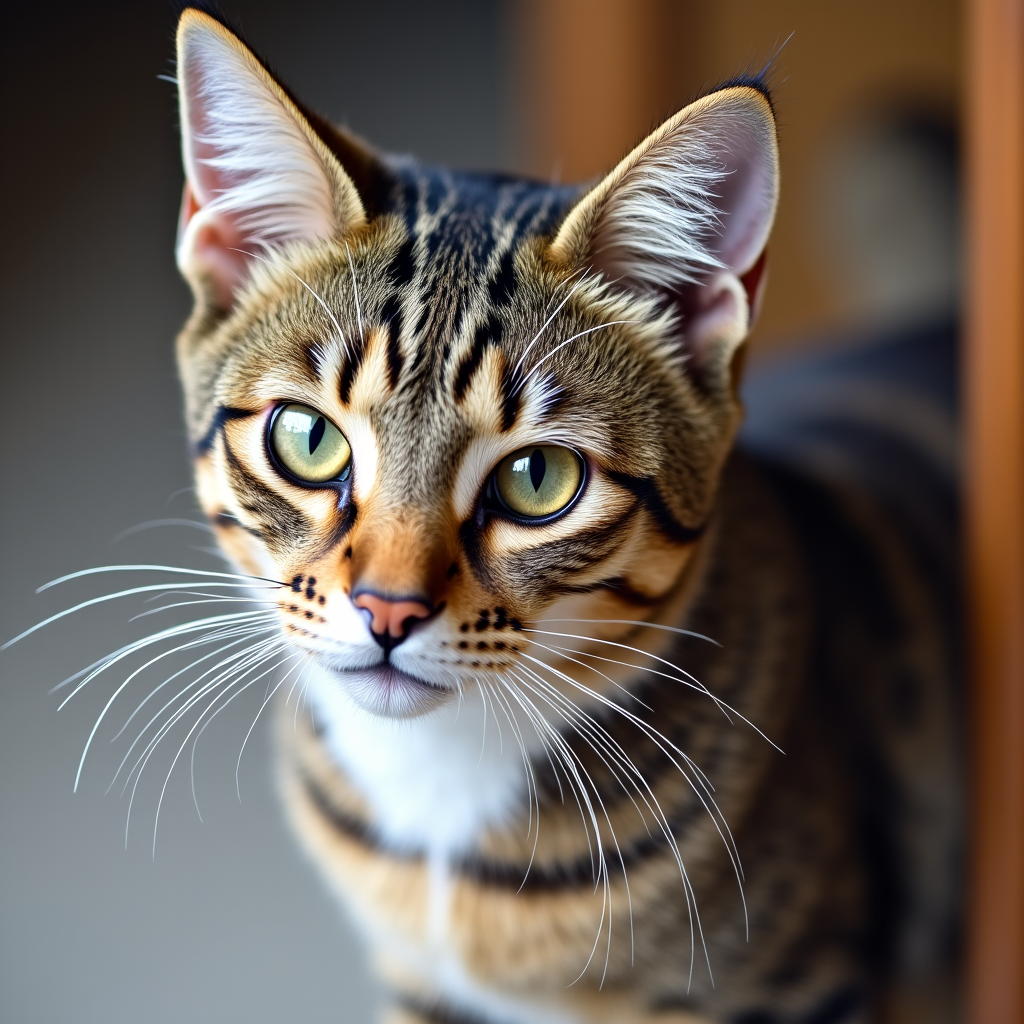

In [4]:
generator = torch.Generator(device="cuda").manual_seed(0)
prompt = "A cat"

image = pipe(
    prompt,
    height=1024,
    width=1024,
    guidance_scale=7.5,
    num_inference_steps=30,
    max_sequence_length=512, # For prompt
    generator=generator
).images[0]

image

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

query_dist = []
key_dist = []
value_dist = []
x_dist = []
query_sim = []
key_sim = []
value_sim = []
x_sim = []

query_dist_single = []
key_dist_single = []
value_dist_single = []
x_dist_single = []
query_sim_single = []
key_sim_single = []
value_sim_single = []
x_sim_single = []
for layer in pipe.transformer.transformer_blocks:
    query_dist.append(layer.attn.processor.query_dist)
    key_dist.append(layer.attn.processor.key_dist)
    value_dist.append(layer.attn.processor.value_dist)
    x_dist.append(layer.attn.processor.x_dist)
    query_sim.append(layer.attn.processor.query_sim)
    key_sim.append(layer.attn.processor.key_sim)
    value_sim.append(layer.attn.processor.value_sim)
    x_sim.append(layer.attn.processor.x_sim)

for layer in pipe.transformer.single_transformer_blocks:
    query_dist_single.append(layer.attn.processor.query_dist)
    key_dist_single.append(layer.attn.processor.key_dist)
    value_dist_single.append(layer.attn.processor.value_dist)
    x_dist_single.append(layer.attn.processor.x_dist)
    query_sim_single.append(layer.attn.processor.query_sim)
    key_sim_single.append(layer.attn.processor.key_sim)
    value_sim_single.append(layer.attn.processor.value_sim)
    x_sim_single.append(layer.attn.processor.x_sim)

query_dist = torch.tensor(query_dist)
key_dist = torch.tensor(key_dist)
value_dist = torch.tensor(value_dist)
x_dist = torch.tensor(x_dist)
query_sim = torch.tensor(query_sim)
key_sim = torch.tensor(key_sim)
value_sim = torch.tensor(value_sim)
x_sim = torch.tensor(x_sim)

query_dist_single = torch.tensor(query_dist_single)
key_dist_single = torch.tensor(key_dist_single)
value_dist_single = torch.tensor(value_dist_single)
x_dist_single = torch.tensor(x_dist_single)
query_sim_single = torch.tensor(query_sim_single)
key_sim_single = torch.tensor(key_sim_single)
value_sim_single = torch.tensor(value_sim_single)
x_sim_single = torch.tensor(x_sim_single)

/tmp/ipykernel_1232135/661832066.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  query_dist = torch.tensor(query_dist)


# Distances

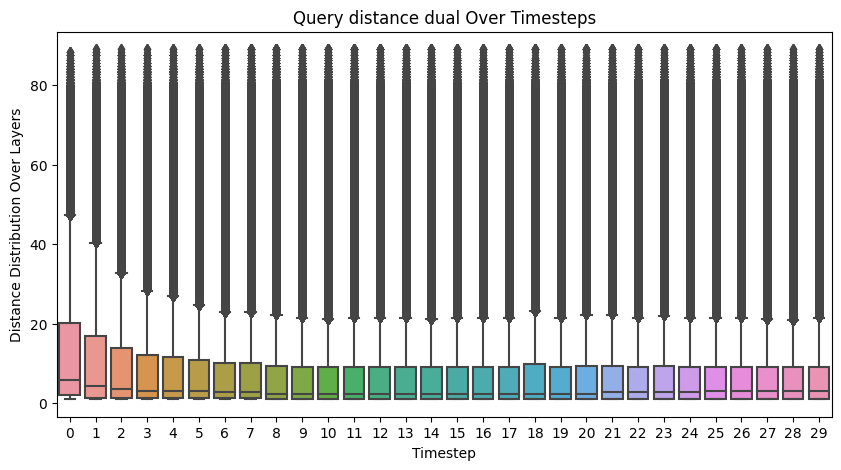

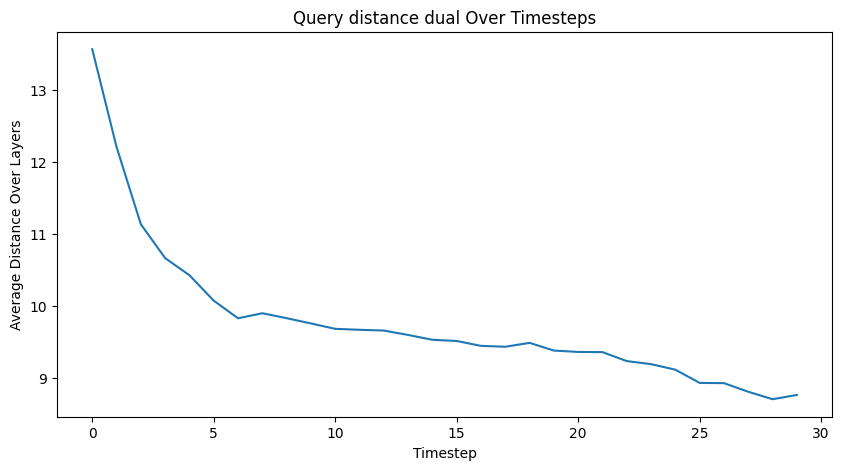

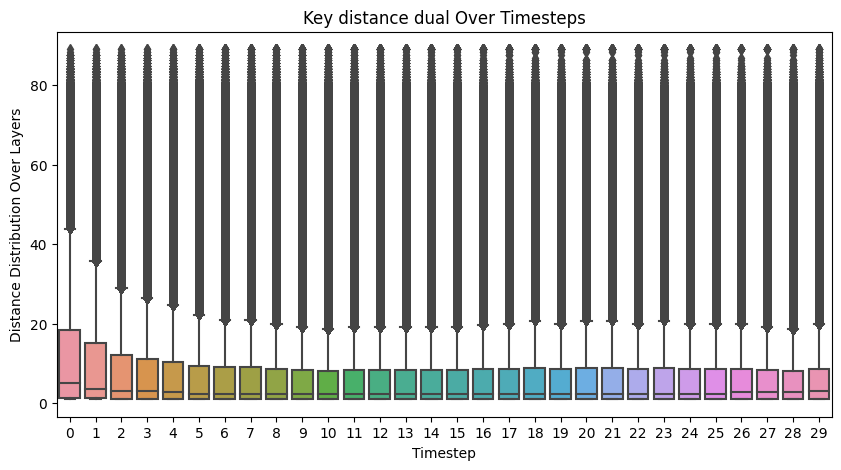

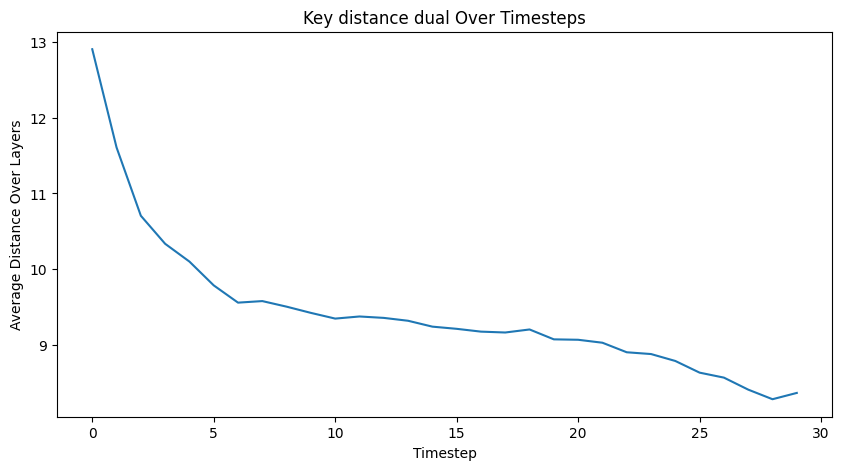

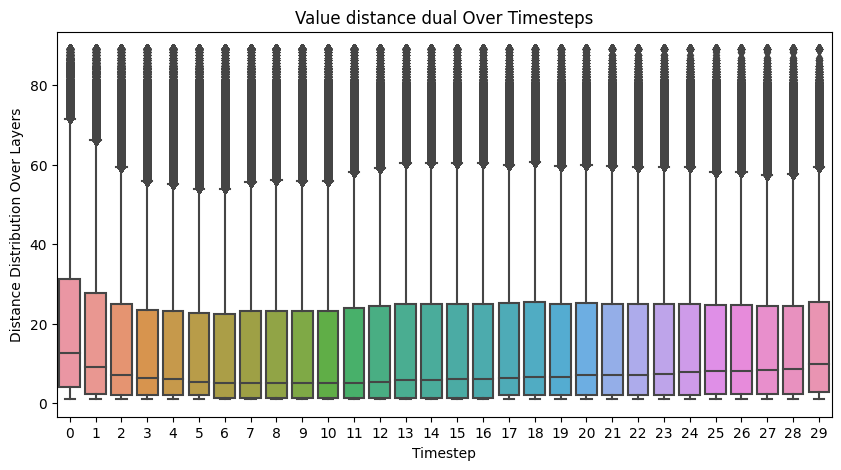

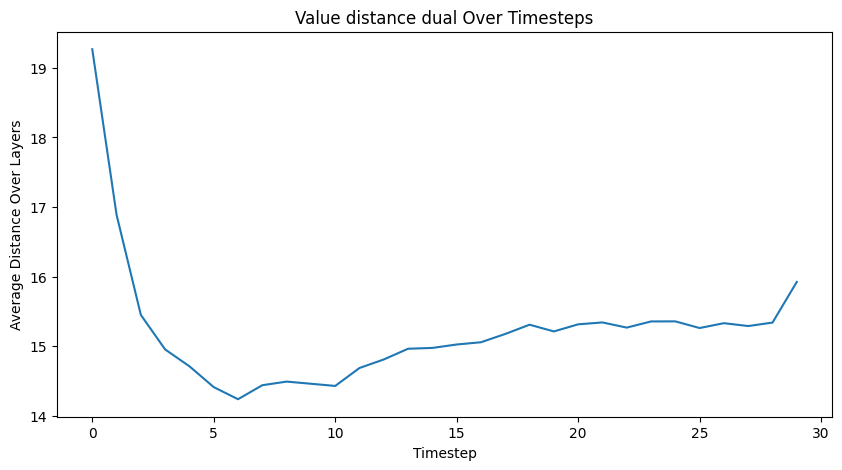

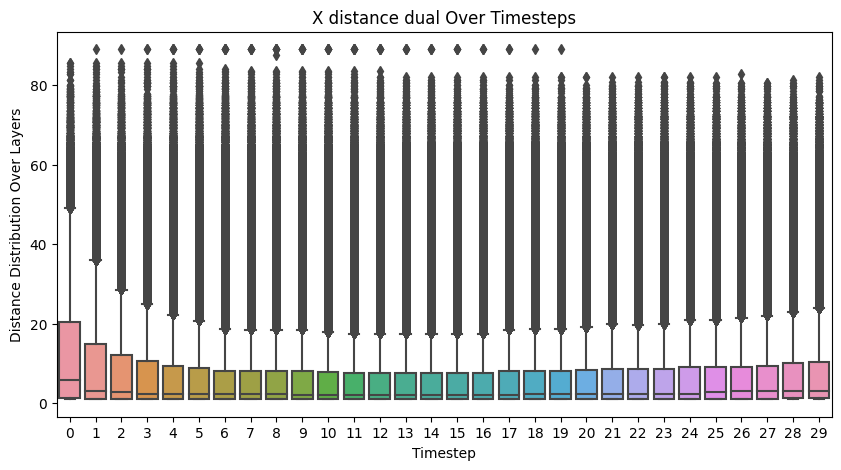

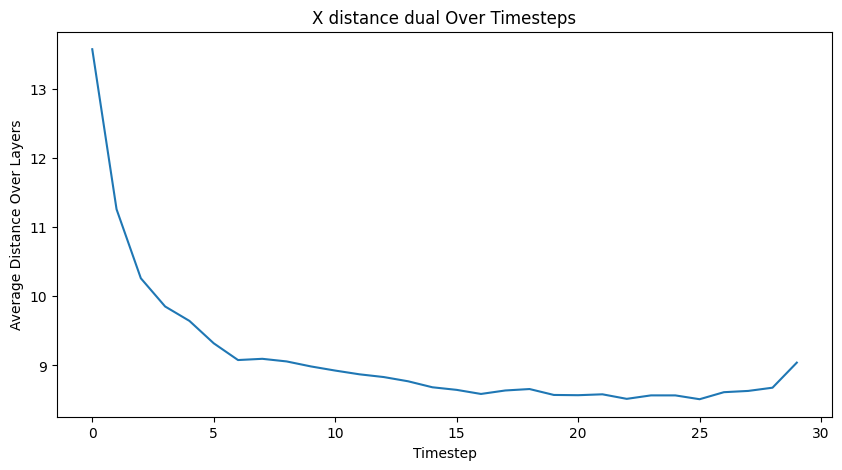

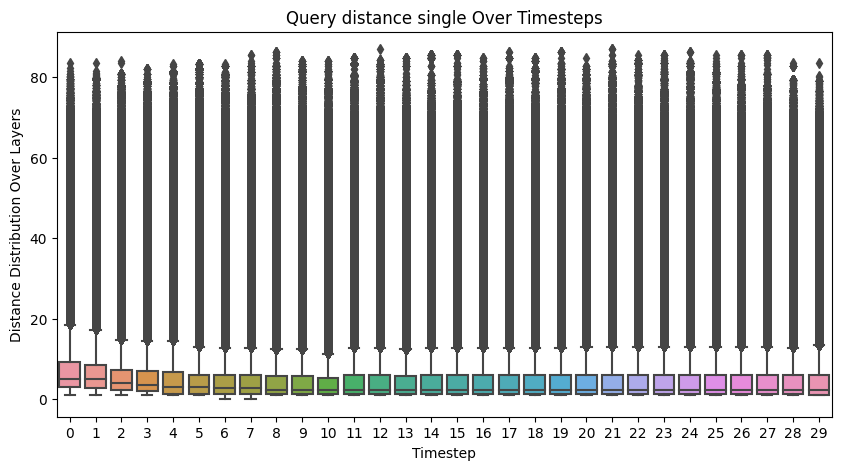

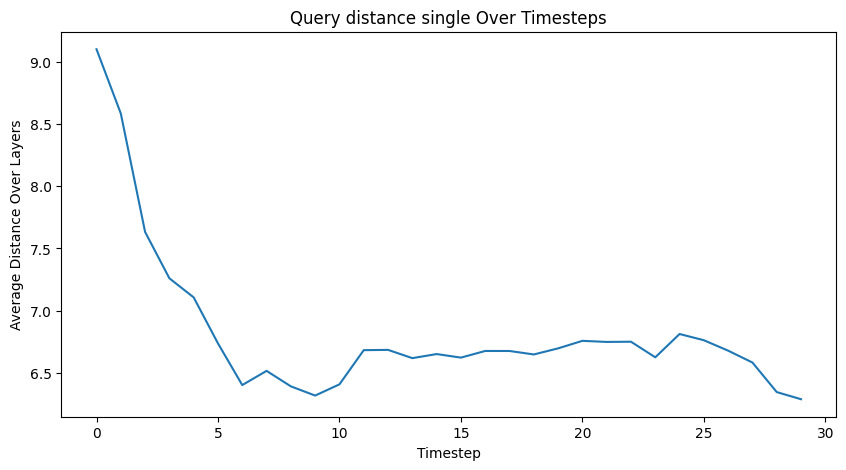

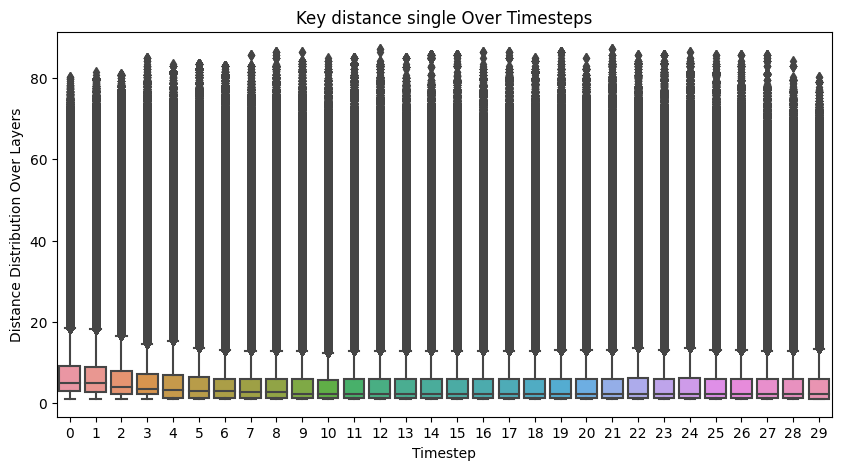

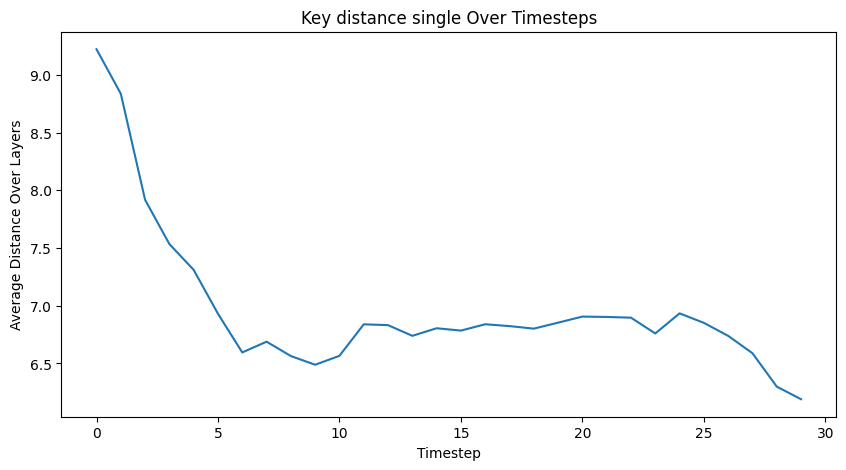

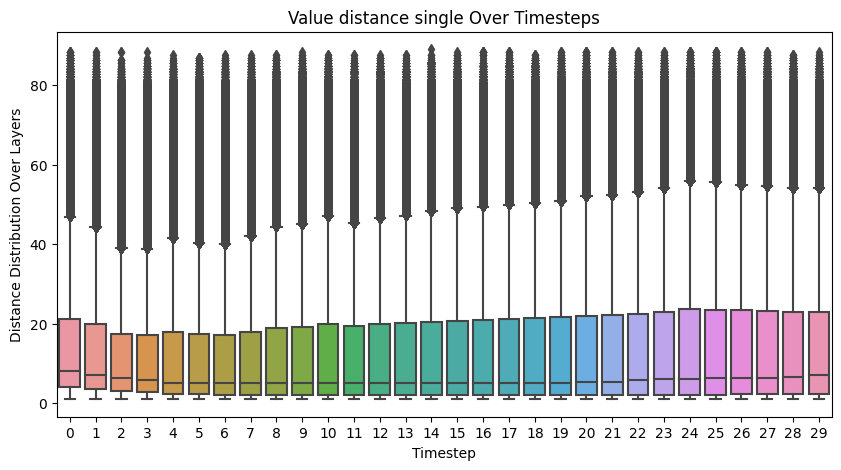

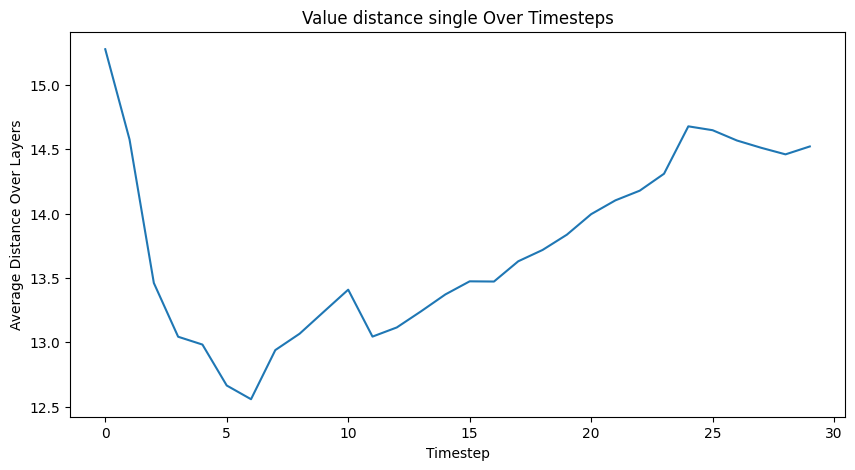

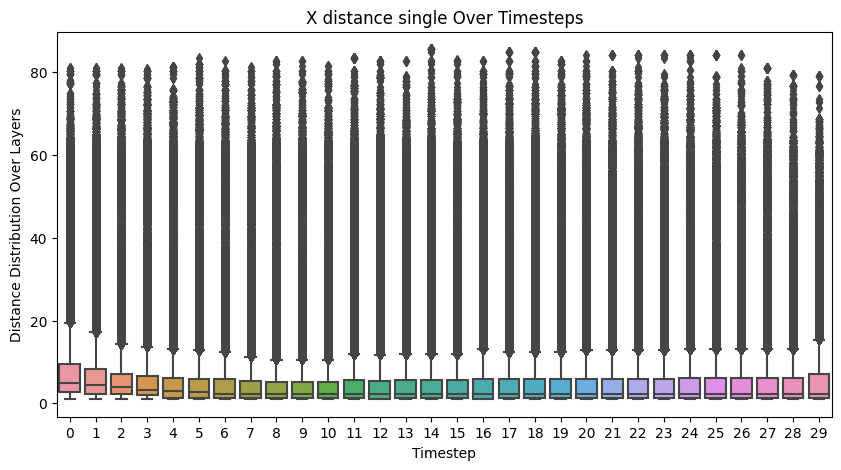

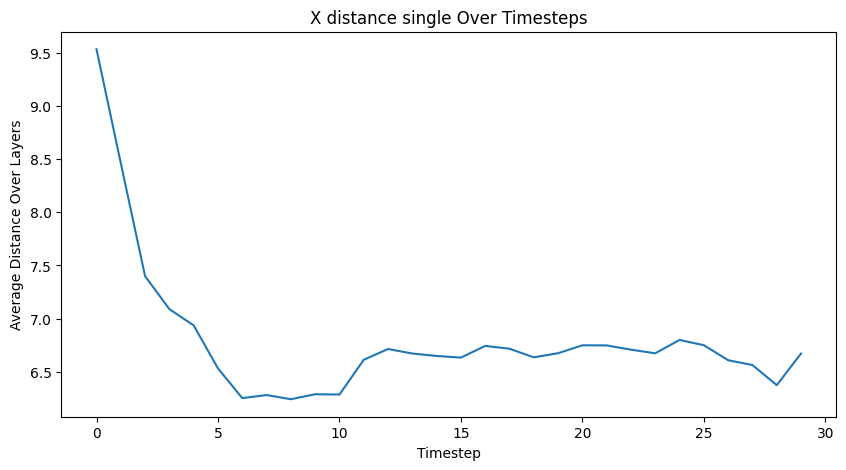

In [6]:
# Distribution of distances over time

# Flatten along the first dimension (layer)
query_dist_ = query_dist.transpose(0, 1).flatten(1, -1)
key_dist_ = key_dist.transpose(0, 1).flatten(1, -1)
value_dist_ = value_dist.transpose(0, 1).flatten(1, -1)
x_dist_ = x_dist.transpose(0, 1).flatten(1, -1)
query_dist_single_ = query_dist_single.transpose(0, 1).flatten(1, -1)
key_dist_single_ = key_dist_single.transpose(0, 1).flatten(1, -1)
value_dist_single_ = value_dist_single.transpose(0, 1).flatten(1, -1)
x_dist_single_ = x_dist_single.transpose(0, 1).flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel("Distance Distribution Over Layers")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel("Average Distance Over Layers")
    plt.show()

plot_once(query_dist_, "Query distance dual")
plot_once(key_dist_, "Key distance dual")
plot_once(value_dist_, "Value distance dual")
plot_once(x_dist_, "X distance dual")
plot_once(query_dist_single_, "Query distance single")
plot_once(key_dist_single_, "Key distance single")
plot_once(value_dist_single_, "Value distance single")
plot_once(x_dist_single_, "X distance single")

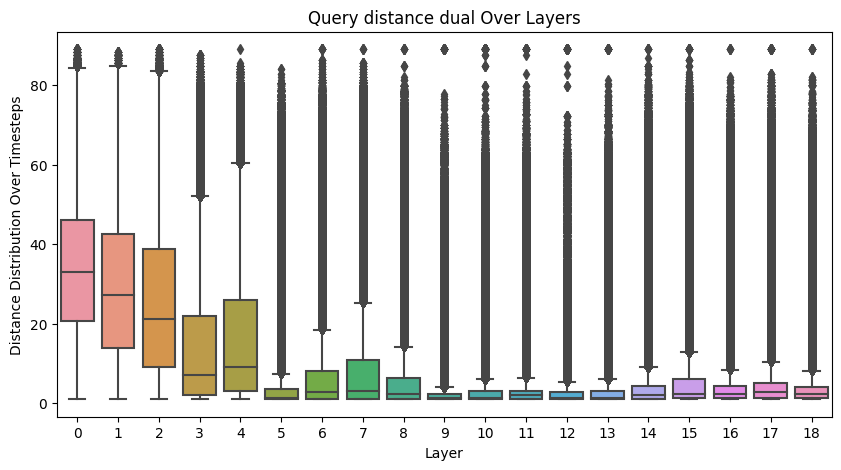

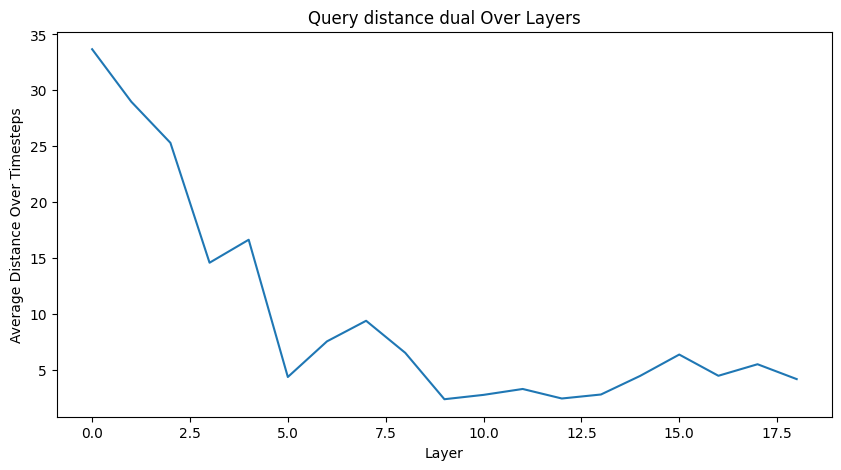

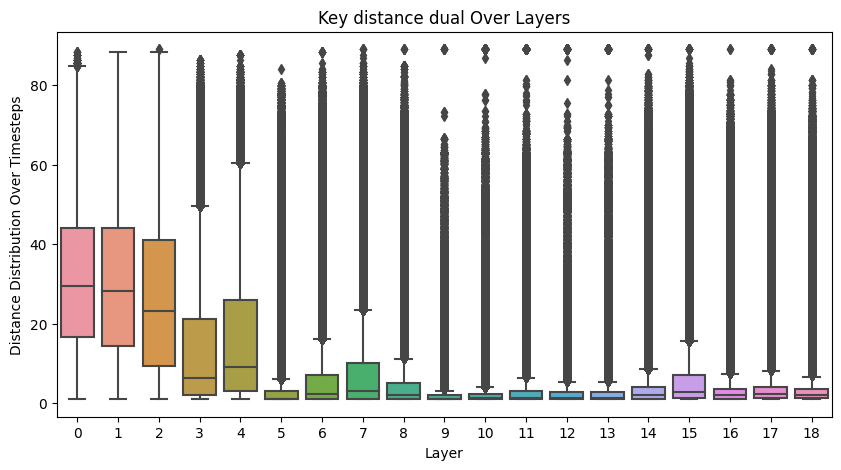

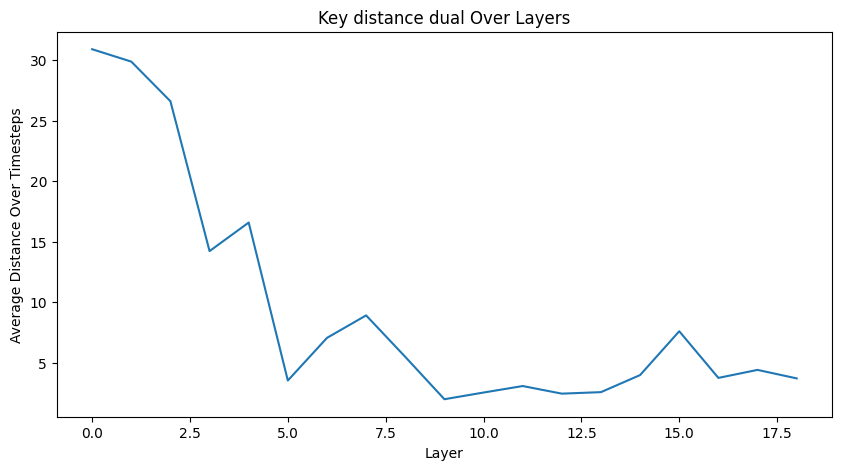

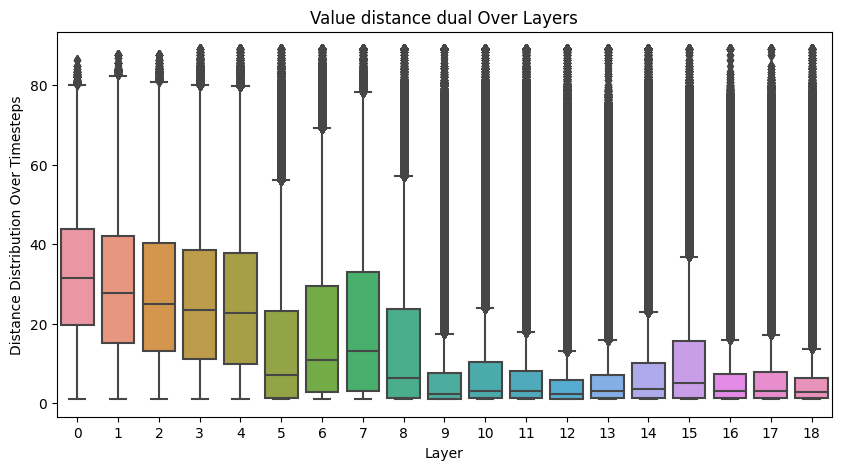

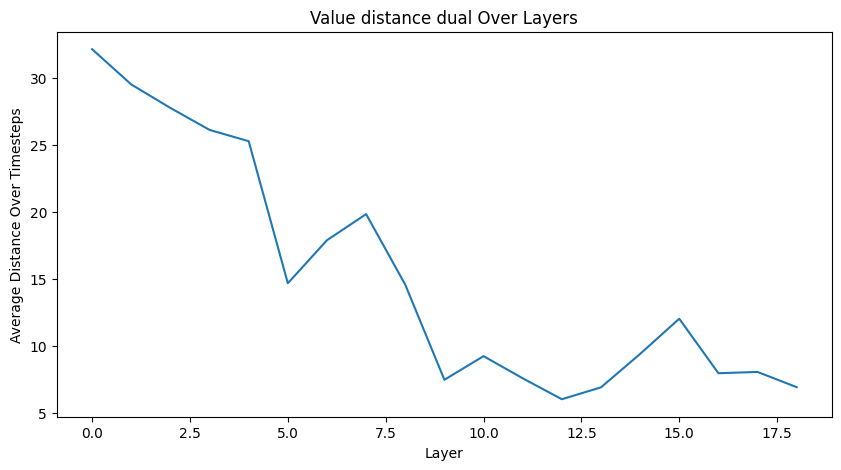

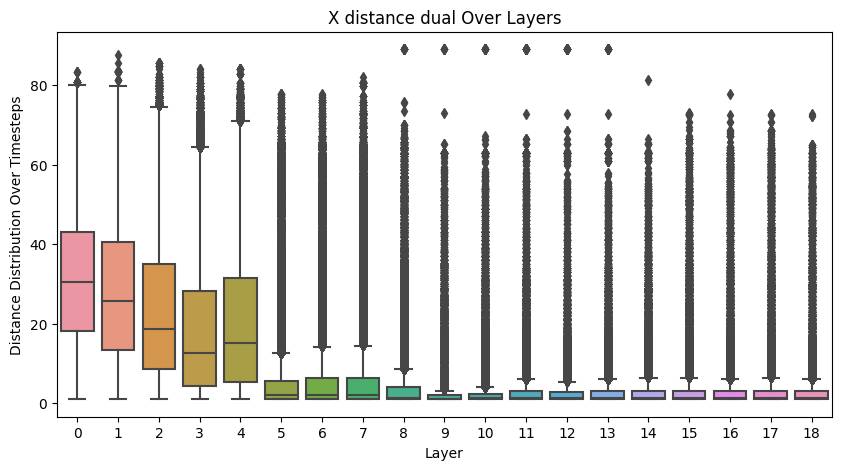

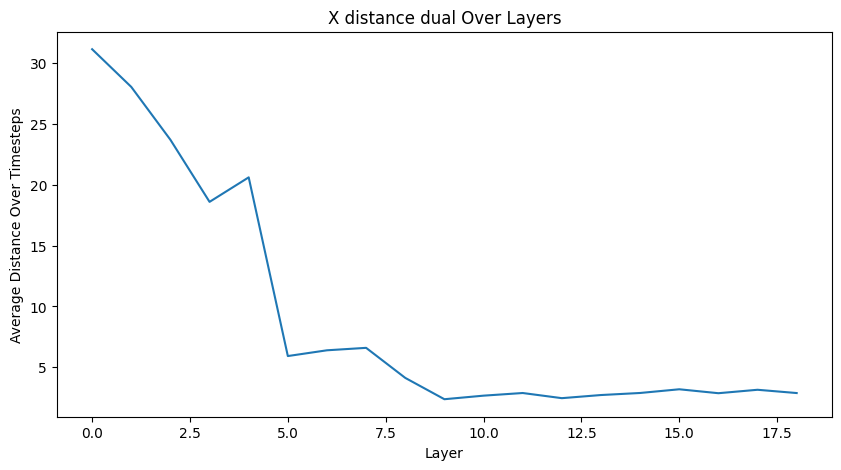

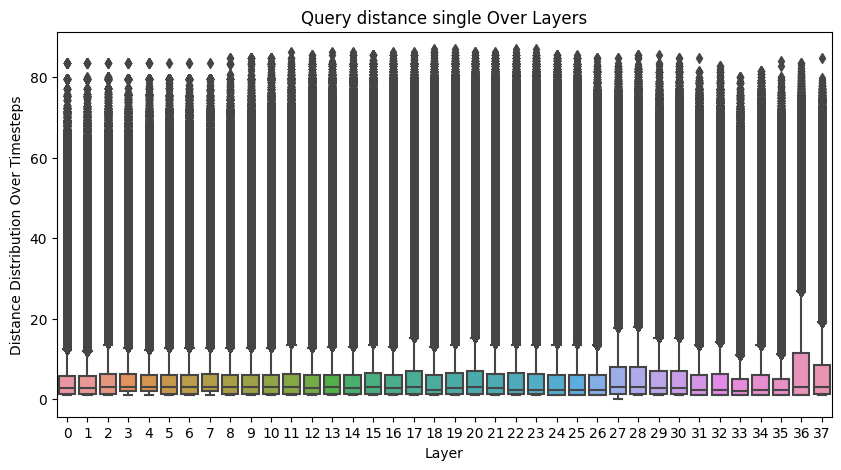

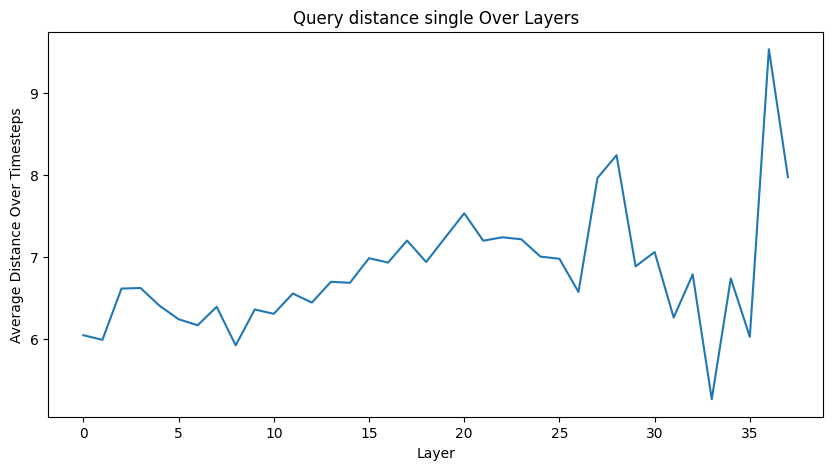

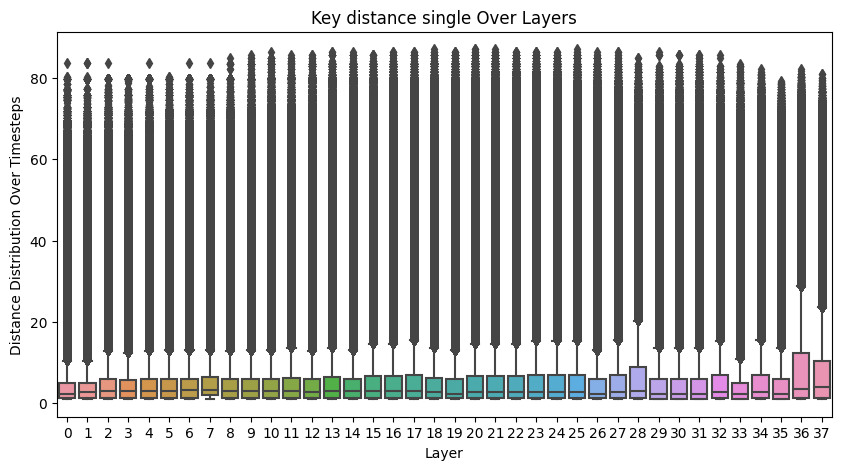

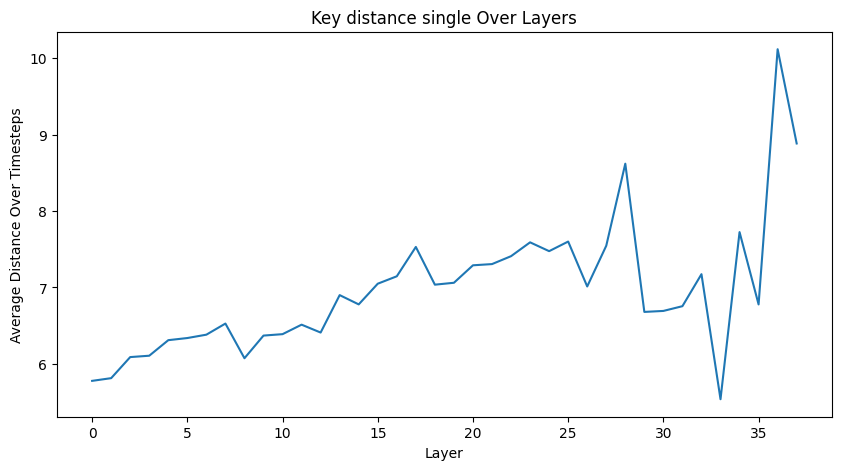

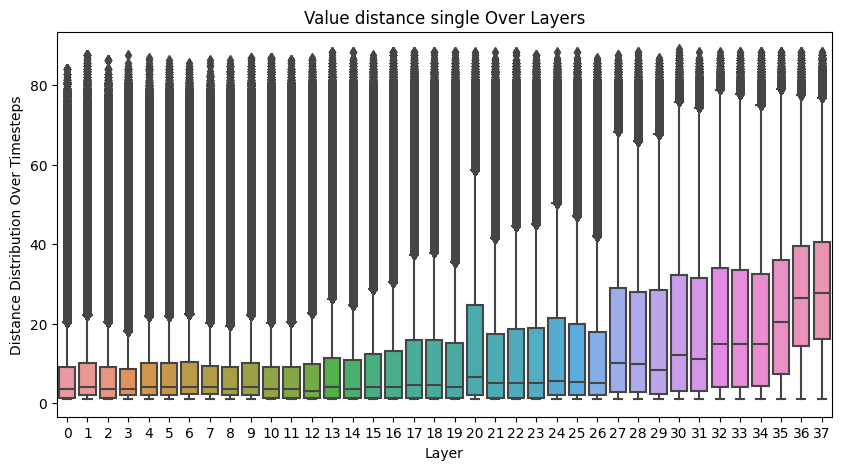

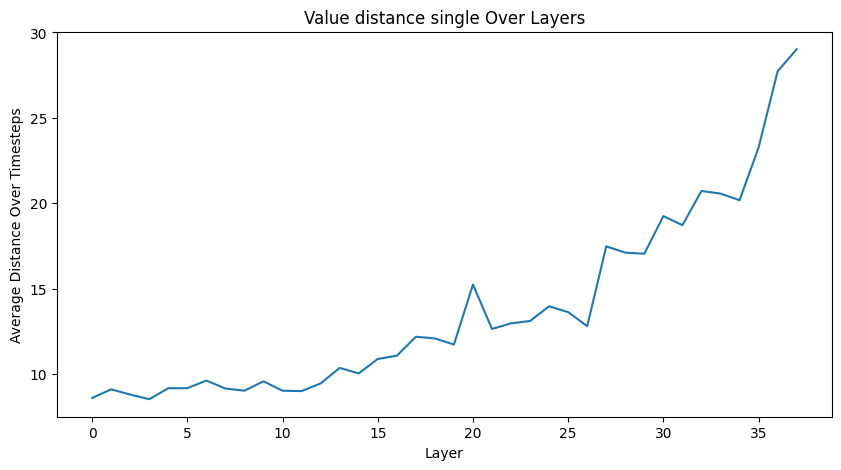

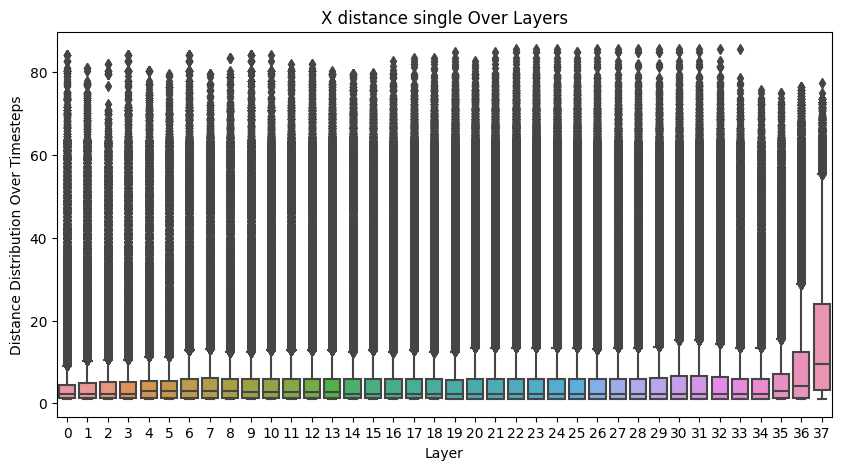

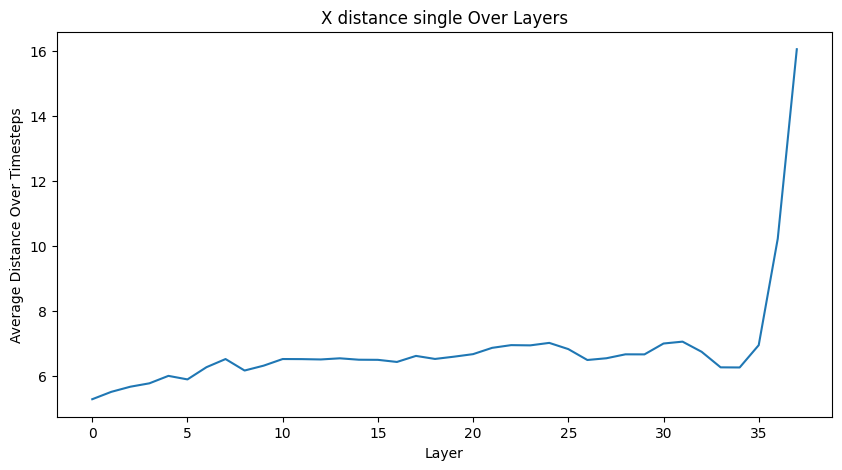

In [7]:
# Distribution of distances over time

# Flatten along the second dimension (layer)
query_dist_ = query_dist.flatten(1, -1)
key_dist_ = key_dist.flatten(1, -1)
value_dist_ = value_dist.flatten(1, -1)
x_dist_ = x_dist.flatten(1, -1)
query_dist_single_ = query_dist_single.flatten(1, -1)
key_dist_single_ = key_dist_single.flatten(1, -1)
value_dist_single_ = value_dist_single.flatten(1, -1)
x_dist_single_ = x_dist_single.flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Distance Distribution Over Timesteps")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Average Distance Over Timesteps")
    plt.show()

plot_once(query_dist_, "Query distance dual")
plot_once(key_dist_, "Key distance dual")
plot_once(value_dist_, "Value distance dual")
plot_once(x_dist_, "X distance dual")
plot_once(query_dist_single_, "Query distance single")
plot_once(key_dist_single_, "Key distance single")
plot_once(value_dist_single_, "Value distance single")
plot_once(x_dist_single_, "X distance single")

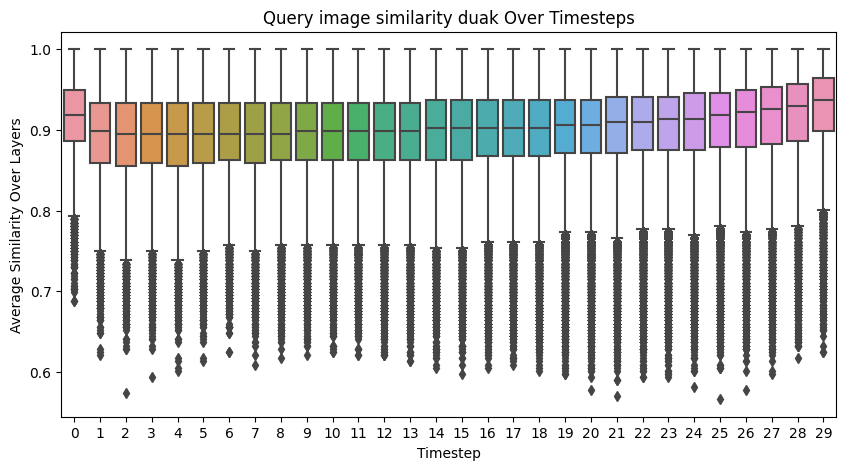

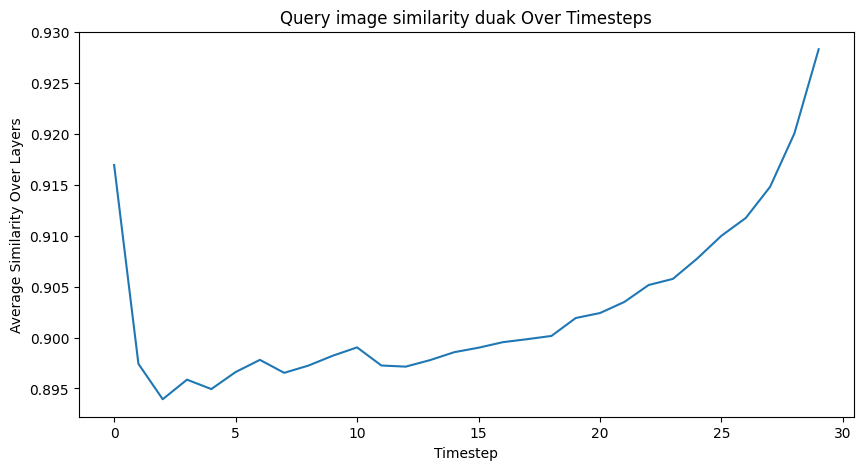

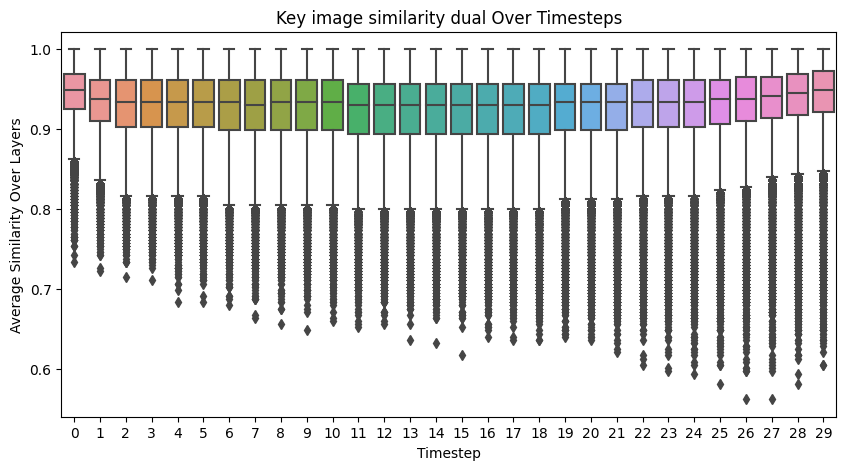

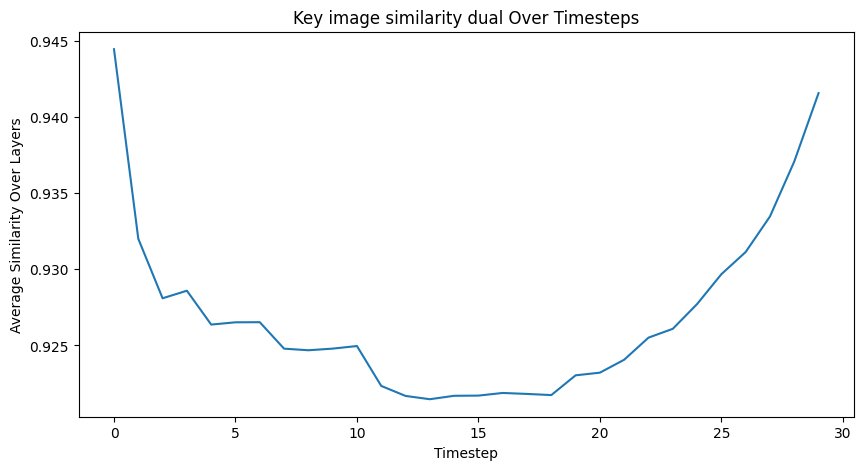

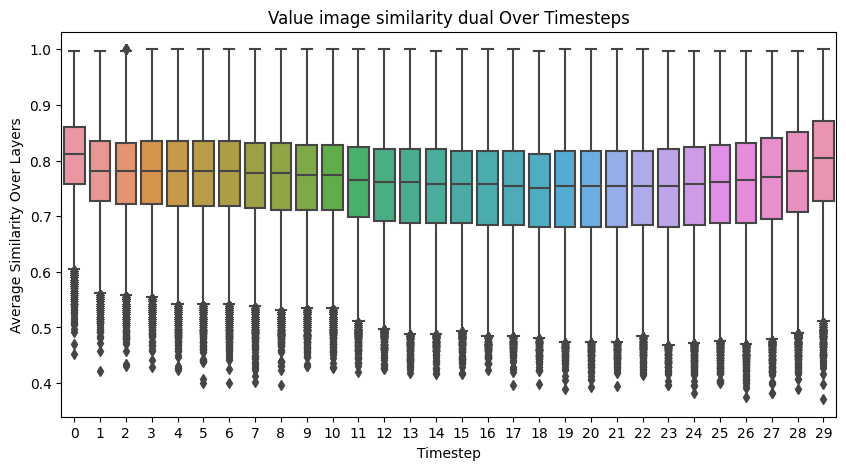

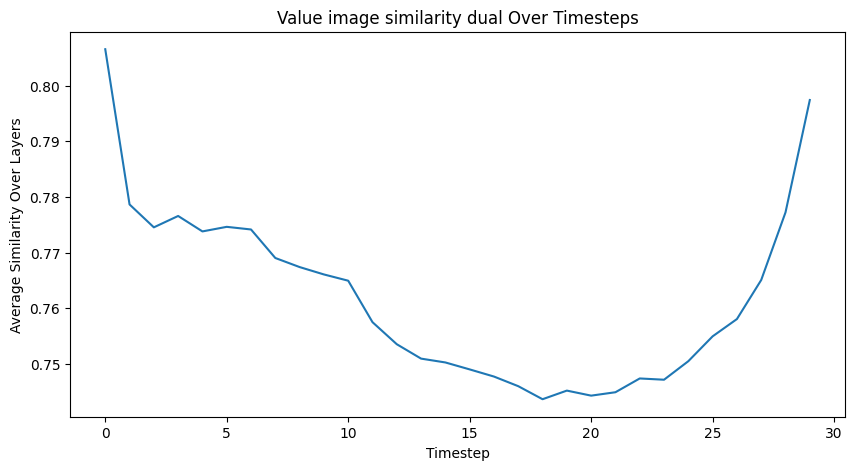

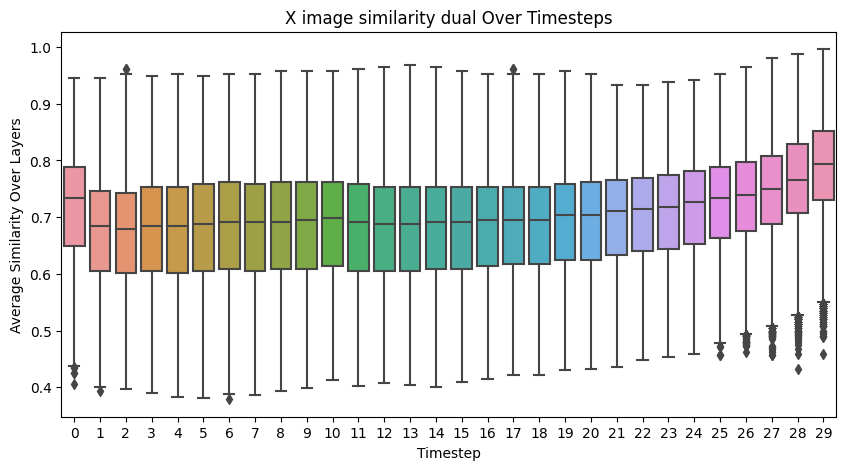

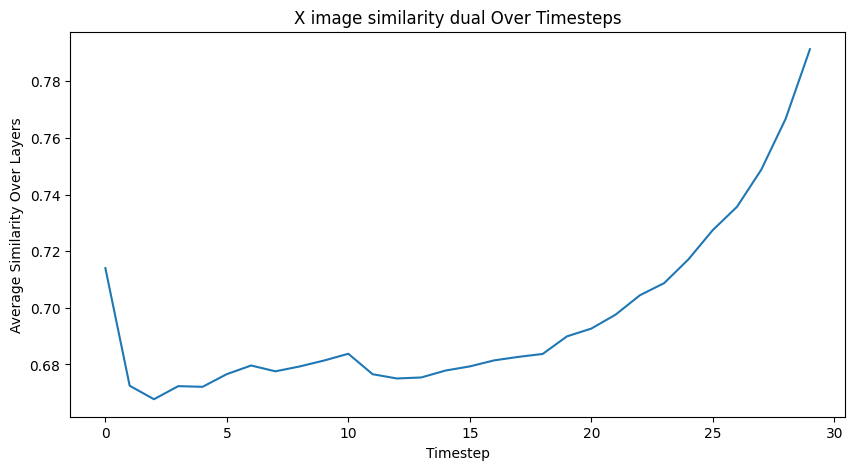

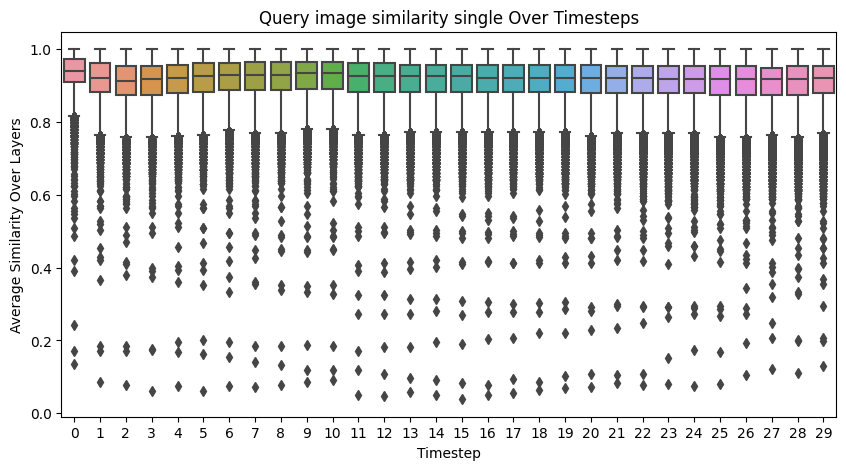

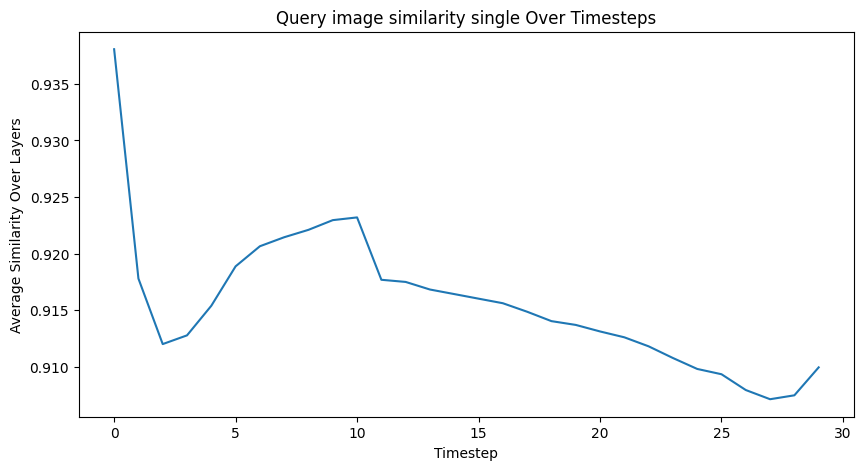

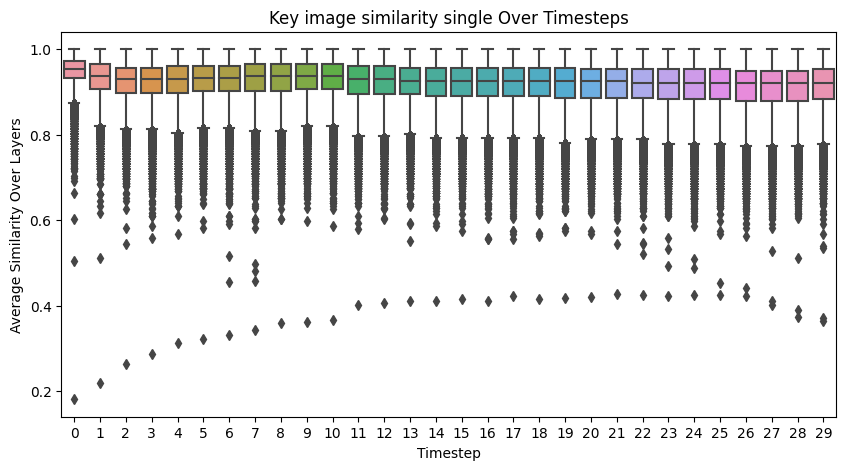

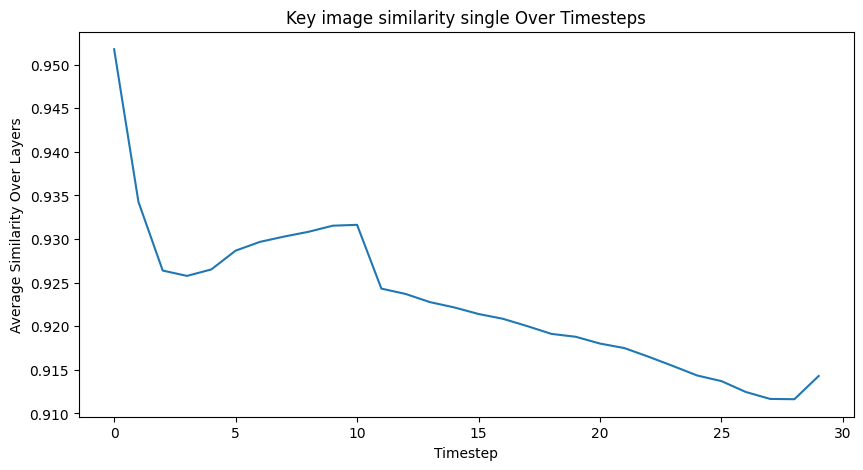

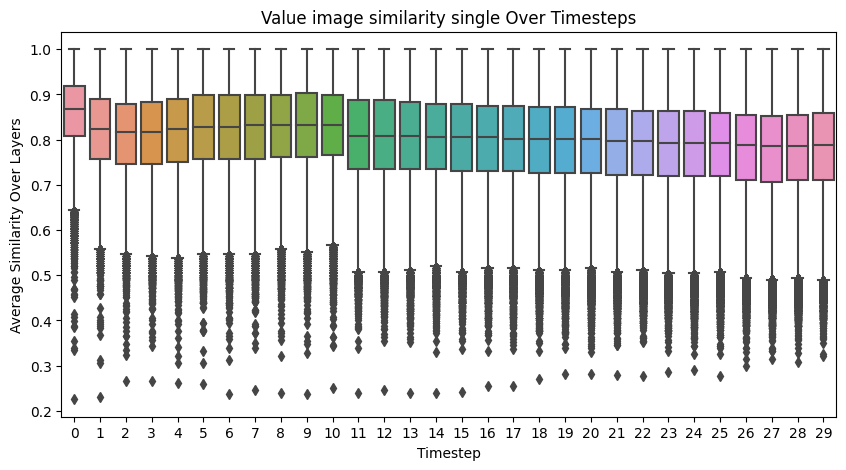

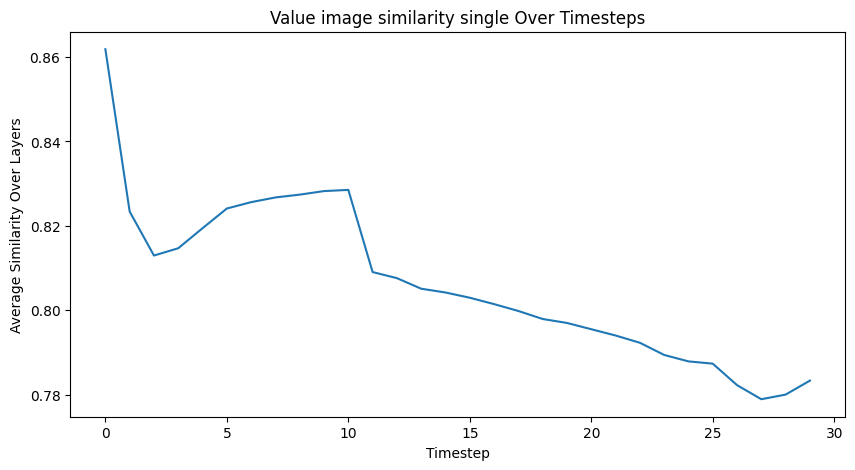

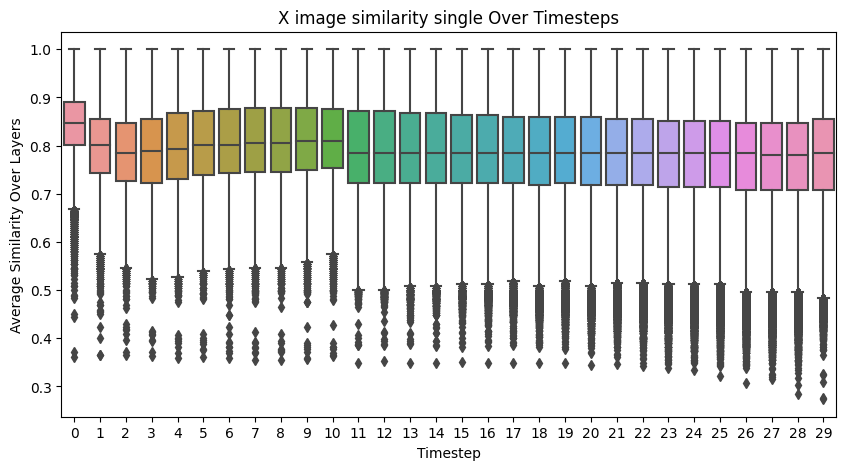

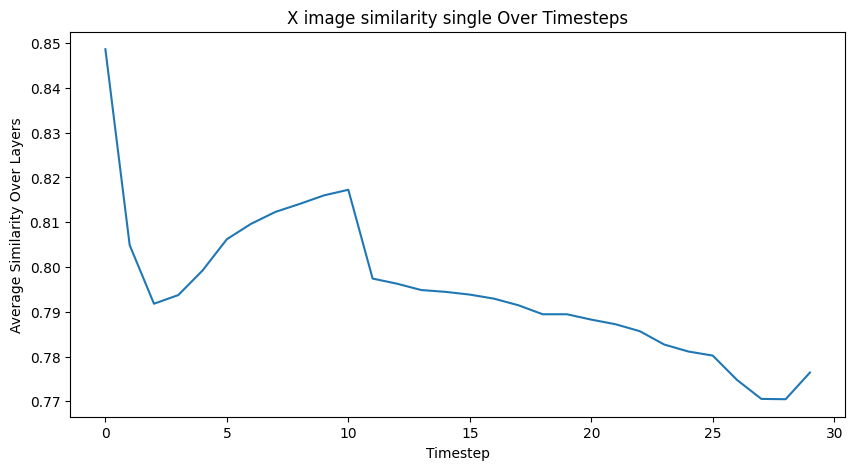

In [8]:
# Distribution of similarity scores over time

# Flatten along the first dimension (layer)
query_img_dist_ = query_sim.transpose(0, 1).flatten(1, -1)
key_img_dist_ = key_sim.transpose(0, 1).flatten(1, -1)
value_img_dist_ = value_sim.transpose(0, 1).flatten(1, -1)
x_img_dist_ = x_sim.transpose(0, 1).flatten(1, -1)
query_img_dist_single_ = query_sim_single.transpose(0, 1).flatten(1, -1)
key_img_dist_single_ = key_sim_single.transpose(0, 1).flatten(1, -1)
value_img_dist_single_ = value_sim_single.transpose(0, 1).flatten(1, -1)
x_img_dist_single_ = x_sim_single.transpose(0, 1).flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel("Average Similarity Over Layers")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel("Average Similarity Over Layers")
    plt.show()

# plot_once(query_dist_, "Query distance")
# plot_once(key_dist_, "Key distance")
plot_once(query_img_dist_, "Query image similarity duak")
plot_once(key_img_dist_, "Key image similarity dual")
plot_once(value_img_dist_, "Value image similarity dual")
plot_once(x_img_dist_, "X image similarity dual")
plot_once(query_img_dist_single_, "Query image similarity single")
plot_once(key_img_dist_single_, "Key image similarity single")
plot_once(value_img_dist_single_, "Value image similarity single")
plot_once(x_img_dist_single_, "X image similarity single")

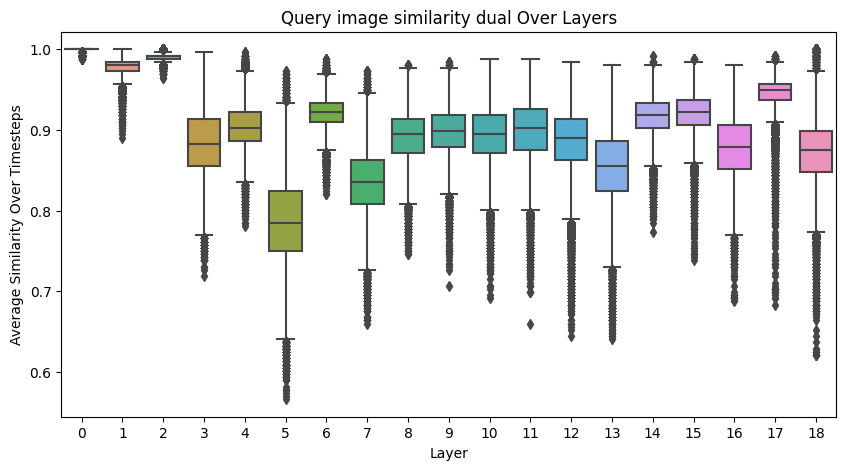

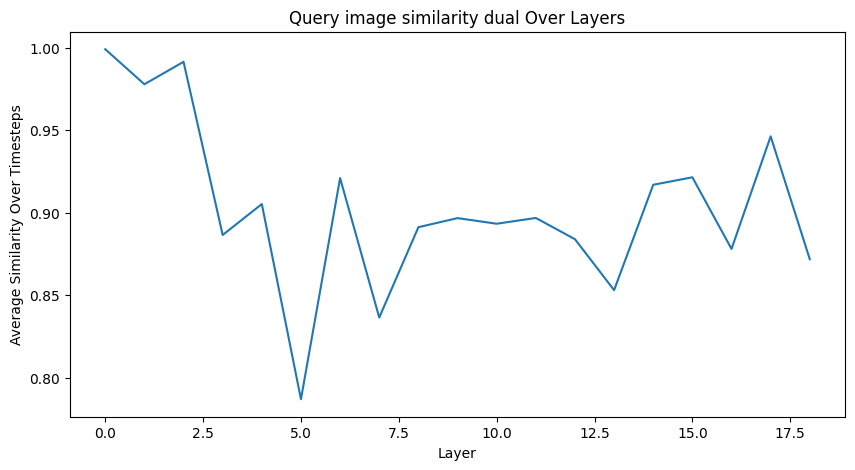

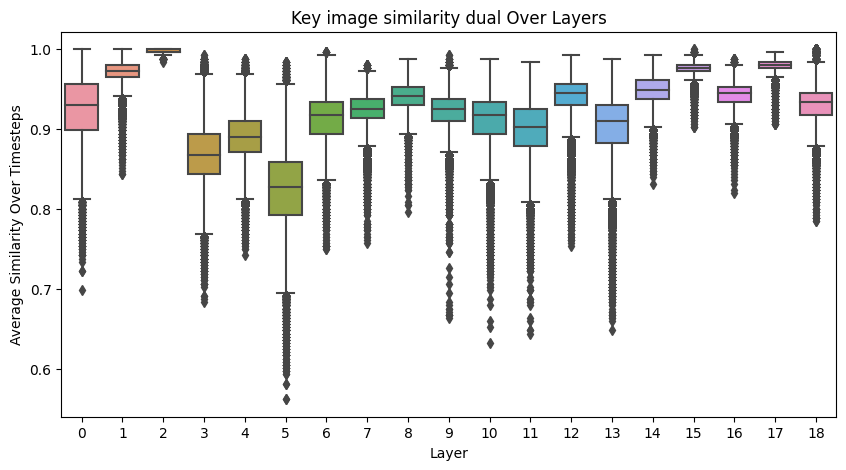

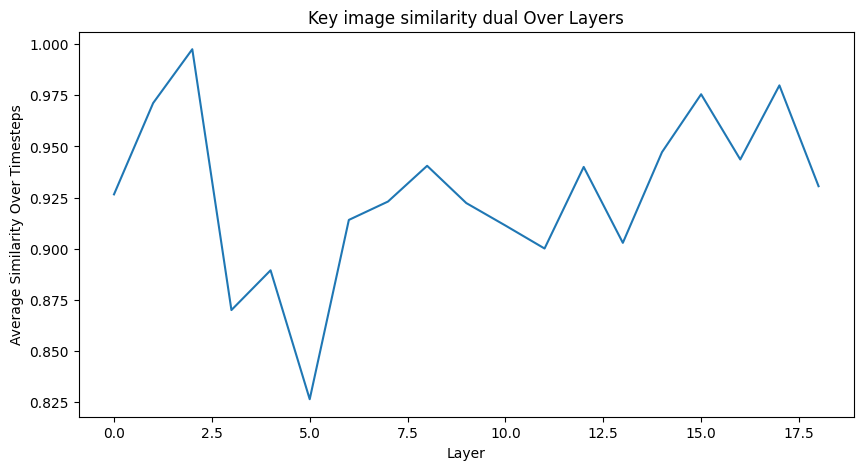

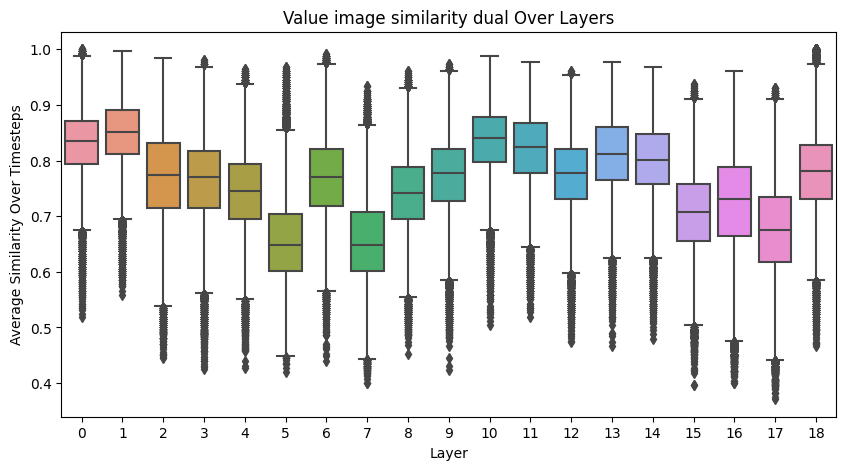

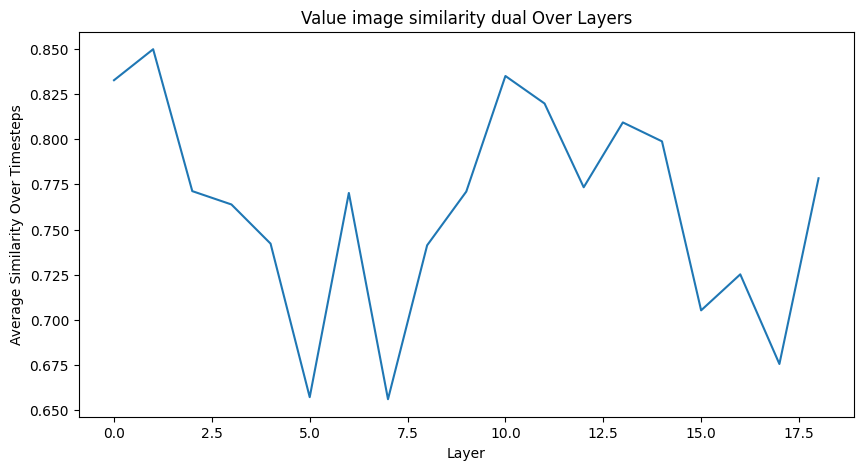

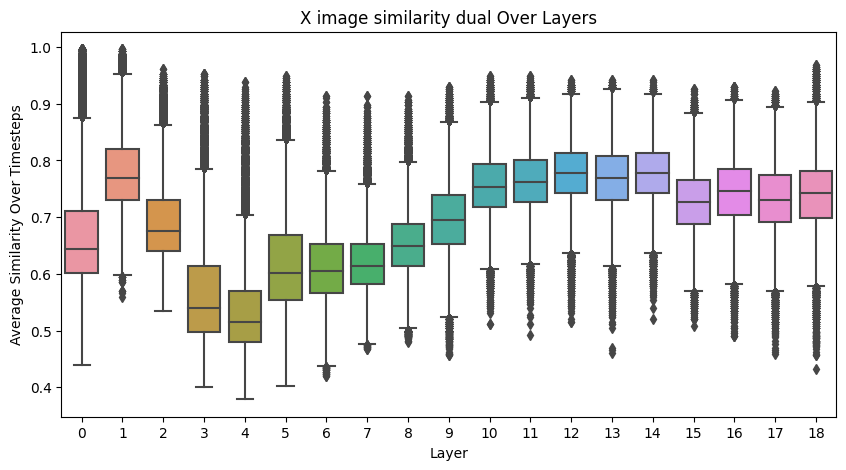

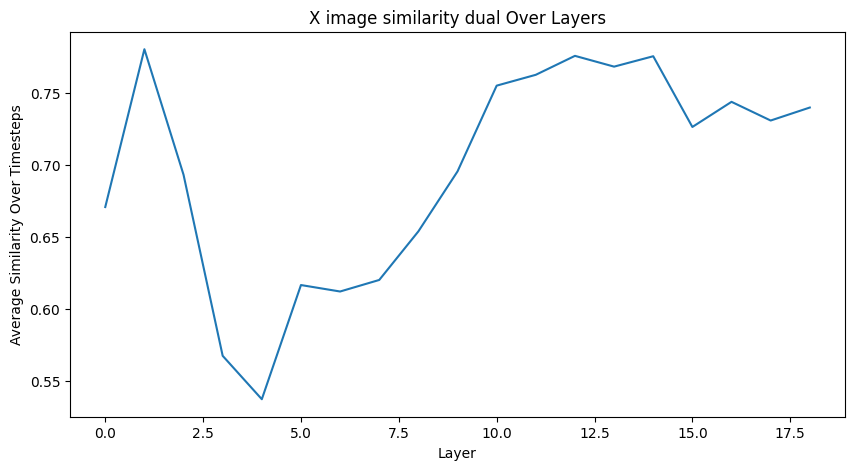

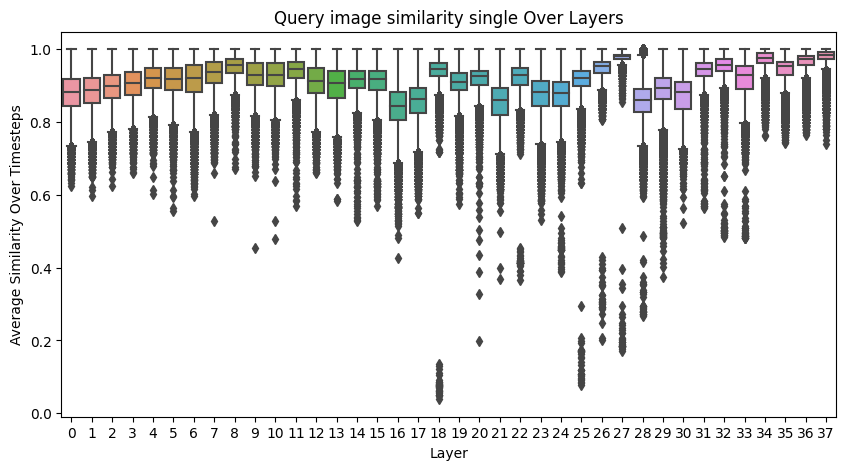

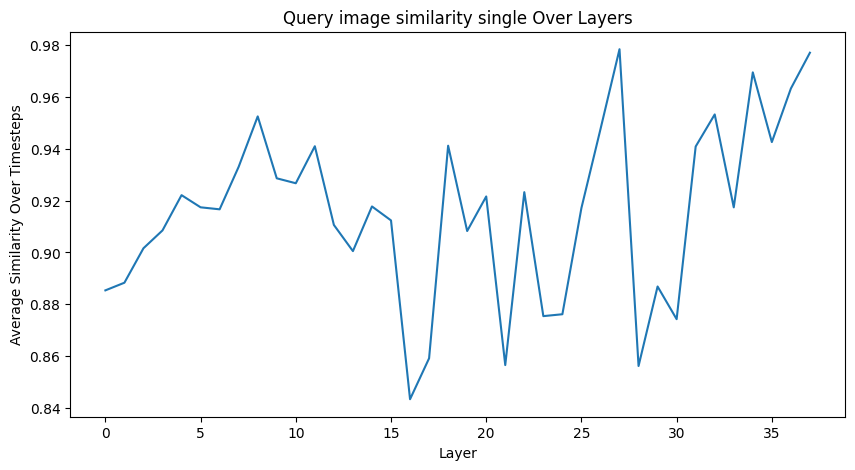

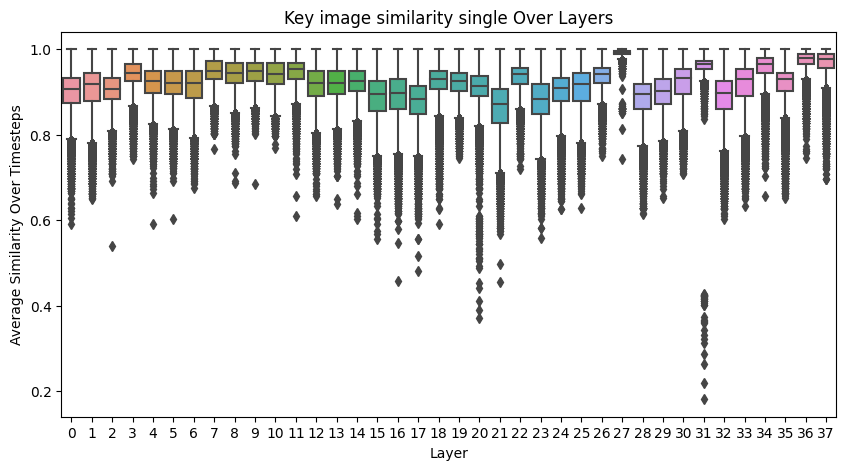

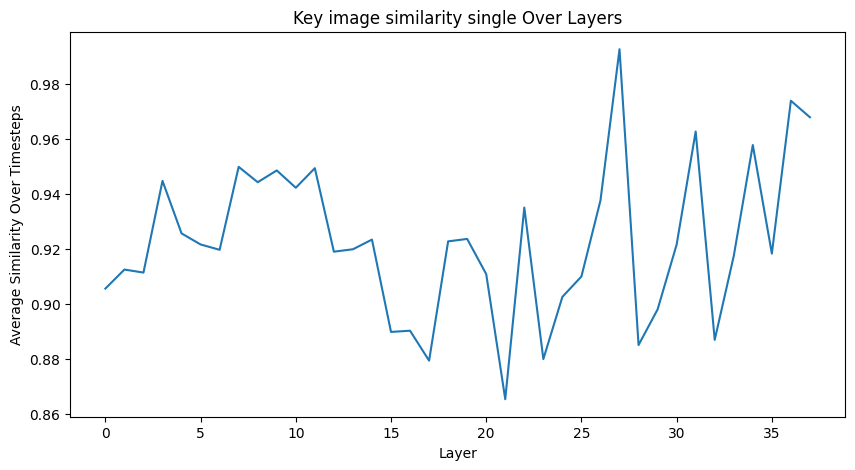

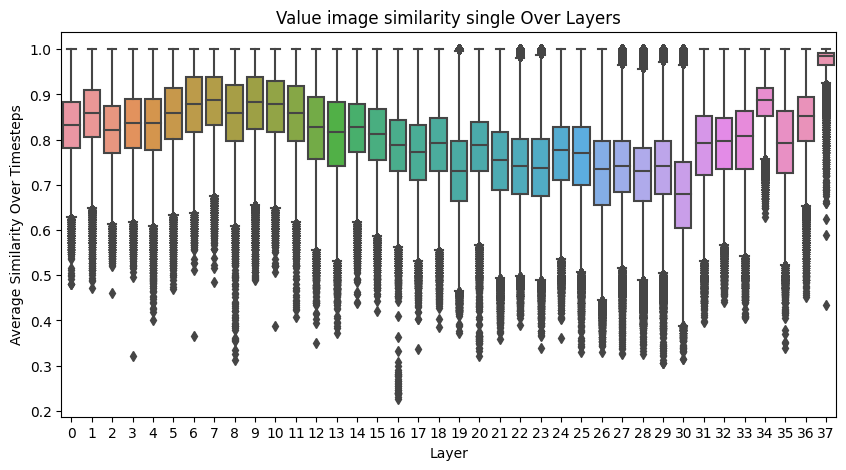

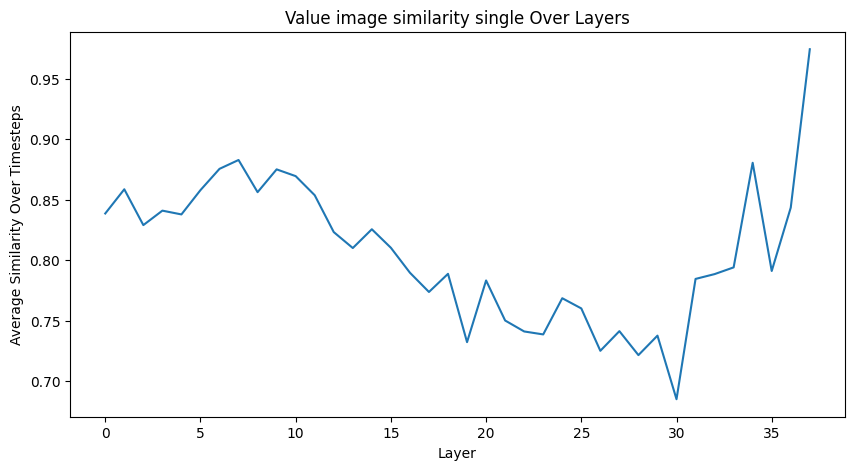

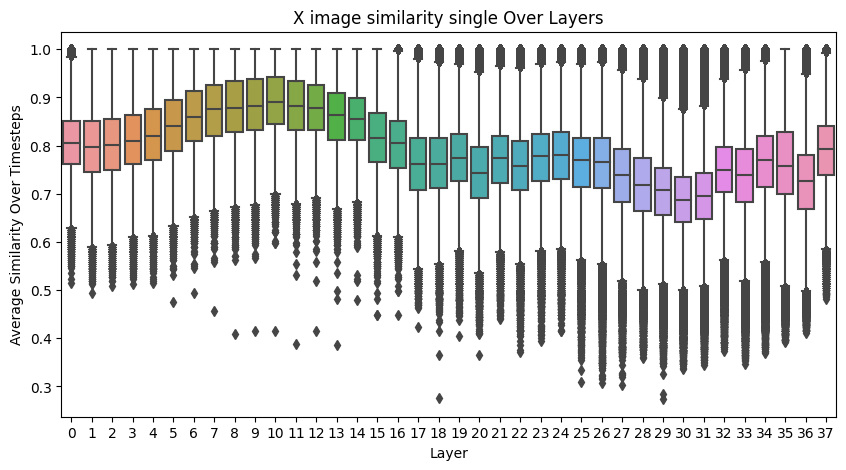

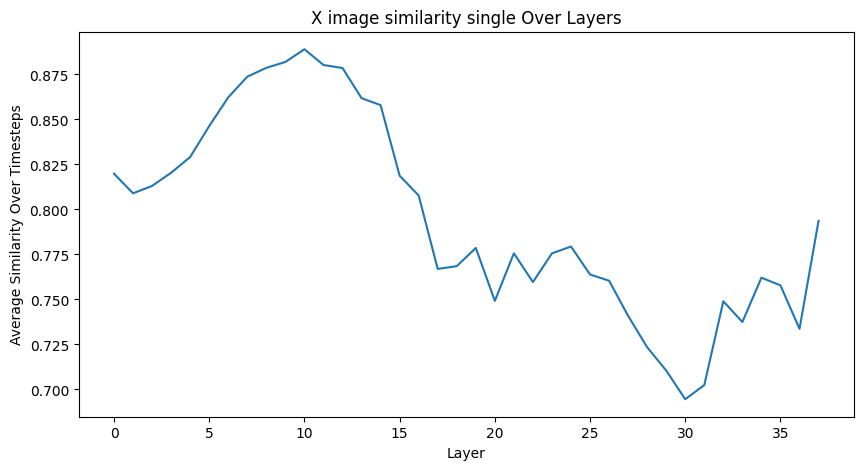

In [9]:
# Distribution of distances over time

# Flatten along the second dimension (layer)
query_img_dist_ = query_sim.flatten(1, -1)
key_img_dist_ = key_sim.flatten(1, -1)
value_img_dist_ = value_sim.flatten(1, -1)
x_img_dist_ = x_sim.flatten(1, -1)
query_img_dist_single_ = query_sim_single.flatten(1, -1)
key_img_dist_single_ = key_sim_single.flatten(1, -1)
value_img_dist_single_ = value_sim_single.flatten(1, -1)
x_img_dist_single_ = x_sim_single.flatten(1, -1)

# Plot over time
def plot_once(dist, title):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=dist.mT.cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Average Similarity Over Timesteps")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(dist.mean(-1).cpu().numpy())
    plt.title(title + " Over Layers")
    plt.xlabel("Layer")
    plt.ylabel("Average Similarity Over Timesteps")
    plt.show()

plot_once(query_img_dist_, "Query image similarity dual")
plot_once(key_img_dist_, "Key image similarity dual")
plot_once(value_img_dist_, "Value image similarity dual")
plot_once(x_img_dist_, "X image similarity dual")
plot_once(query_img_dist_single_, "Query image similarity single")
plot_once(key_img_dist_single_, "Key image similarity single")
plot_once(value_img_dist_single_, "Value image similarity single")
plot_once(x_img_dist_single_, "X image similarity single")